# Pipeline para la geocodificacion de usuarios


## Resumen 
La actual pipeline esta pensada para aproximar la geolocalizacion de los usuarios del plan de salud del HI (desde el 2014 al 2020) en base a 3 varaibles proveidas: <br>
`provincia_part`, `cp_part`, `loc_part`.<br>

Un analisis exploratorio reveló que usualmente los usuarios escriben campos erroneos en la localidad (a veces el municipio, a veces sencillamente comente errores tipeando) y tambien en la provincia (ej Bariloche anotado como Capital Federal, etc). 

Un primer analisis exploratorio del padron revelo los siguientes valores ausentes para los 87402 usuarios evaluados:
```bash 
nacionalidad       206

provincia_part    4820

loc_part           263

cp_part              1
```
A su vez encontramos que usualmente los CP al ser valores estrucurados son bastante fidedignos de la verdadera ubicacion del usuario. Es decir, pueden ser muy precisos, indicando una localidad especifica. Sin embargo a veces no lo son tanto, pudiendo inclusive corresponder a dos provincias al mismo tiempo (mas comun en el interior del pais).

Si nos concentramos en los usarios que son mas relevantes dada su unicacion geografica (BS AS y CABA) observamos que componen el 93.7% del padrón (81925 usuarios). En el caso de los socios de CABA, la respuesta mas comun a la pregunta de la localidad en la que viven (`loc_part`) fue CABA (36988) o CDAD AUTONOMA BS AS (6703). Este ultimo probablemente sea un campo estructurado pero no se comprende por que no todos los usuarios usaron esta modalidad. Quizas la base tomo informacion de distintas fuentes y formularios (sin embargo ambas modalidades, CABA y CDA aparecen en todos los años).

In [51]:
# Cargando librerias
import pandas as pd
import pickle
import shapely
import geopandas as gpd
import descartes
import geoplot
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('../HI_usuarios_completos.csv',  encoding='latin-1') # Datos de los usuarios 

In [22]:
df.sample(5)

,anio_ing,nacionalidad,provincia_part,loc_part,cp_part
46450,2017,AR,CF,CABA,1416
15759,2015,RU,BA,MUNRO,1605
85789,2020,AR,CF,CDAD AUTONOMA BS AS,1432
44036,2017,AR,BA,MARCOS PAZ,1727
24377,2016,AR,BA,HAEDO,1706


# Algoritmo utilizado

1) Asignar campos segun codigo postal (`cp_part`)
- 1.1) Si es de Capital ver si el CP corresponde a una localidad unica (barrio). Si es asi se asigna Localidad, Departamento (Comuna) y Provincia<br>
-  1.2) Si no corresponde a una localidad unica se checa si el CP corresponde a una unica comuna. Si es asi se asigna solo Departamento y Provincia. Sino solo se asigna Provincia `CIUDAD AUTONOMA DE BUENOS AIRES`.<br>
- 1.3) Si es de provincia se checa si el CP corresponde a una unica localidad. Si es asi se asigna localidad y Provincia (no tenemos una tabla que linkee departamentos con CP).<br>
- 1.4) Si no corresponde a una unica localidad se checa si el CP corresponde a una unica provincia. Si es asi se asgina solo Provincia. En todos los casos, cuando el CP no es suficiente para asignar un campo especifico se coloca el valor `NO UNICA/O LOCALIDAD/DEPARTAMENTO/PROVINCIA <br>

2) Una vez asignado los campos anterios se correran la funciones de `get_centroides.py` con las siguientes reglas:<br>
- 2.1) Si hay un campo de Provincia registrada se ingresa a la funcion.<br>
- 2.1.1) Si hay un campo de localidad se ingresa a la funcion. Se obtiene el centroide y el id normalizado por INDEC para la localidad.<br>
- 2.1.2) Si no hay localidad habra dos opciones, dependiendo si es de Capital o Provincia:<br>
    -      Provincia) Se usa el campo Provincia generado y se usa el campo `loc_part` (ingresado por el usuario). Si encuentra una respuesta se agrega la localidad. Sino se agrega centroide de la provincia.<br>
    -     Capital) Se usa la comuna si la hay y se busca por departamento. Si no, se usa el campo 'loc_part' como localidad. Es probabable que no devuelva datos por lo que solo se agrega centroide de Capital Federal.<br>
- 2.2) Si no hay provincia registrada se usa el campo `loc_part`y se ingresa la respuesta. En todos los casos (y campos), si hay  respuesta se ingresa el campo 'NO HUBO REQUEST'
    

In [23]:
augmented_df2 = pickle.load(open('../HI_localizacion_socios.pickle', 'rb'))
augmented_df2.sample(5)

,anio_ing,nacionalidad,provincia_part,loc_part,cp_part,user_id,provincia_por_cp,localidad_por_cp,departamento_por_cp,localidad_por_API,...,provincia_por_API,provincia_id_API,centroide_lat_localidad,centroide_lon_localidad,centroide_lat_municipio,centroide_lon_municipio,centroide_lat_departamento,centroide_lon_departamento,centroide_lat_provincia,centroide_lon_provincia
copy_index,,,,,,,,,,,,,,,,,,,,,
24321,2016,AR,BA,MORENO,1744,ID_24321,BUENOS AIRES,NO UNICA LOCALIDAD,None,MORENO,...,BUENOS AIRES,6,-34.6376,-58.7921,-34.6106,-58.8109,-34.6106,-58.8109,-36.676942,-60.558832
47410,2017,AR,BA,VILLA LUZURIAGA,1753,ID_47410,CP INDEFINIDO,CP INDEFINIDO,None,VILLA LUZURIAGA,...,BUENOS AIRES,6,-34.6731,-58.5939,-34.7702,-58.6254,-34.7702,-58.6254,-36.676942,-60.558832
61526,2018,AR,BA,MORENO,1744,ID_61526,BUENOS AIRES,NO UNICA LOCALIDAD,None,MORENO,...,BUENOS AIRES,6,-34.6376,-58.7921,-34.6106,-58.8109,-34.6106,-58.8109,-36.676942,-60.558832
65512,2018,AR,BA,VILLA LUZURIAGA,1754,ID_65512,BUENOS AIRES,NO UNICA LOCALIDAD,None,VILLA LUZURIAGA,...,BUENOS AIRES,6,-34.6731,-58.5939,-34.7702,-58.6254,-34.7702,-58.6254,-36.676942,-60.558832
492,2014,AR,BA,CIUDAD DE EDUARDO M,1768,ID_492,BUENOS AIRES,VILLA MADERO,None,VILLA EDUARDO MADERO,...,BUENOS AIRES,6,-34.6981,-58.4878,-34.7702,-58.6254,-34.7702,-58.6254,-36.676942,-60.558832


# Conclusiones
Mientras que nuestro dataset inicial contaba con un **5.51%** de valores ausentes en el campo de provincia, tras correr el algoritmo se pasó a **4.33%** de missing values. En otras palabras, tras correr el algoritmo se obtuvo un incremento de **1030** usuarios con un campo de provincia asignado, normalizada y georeferenciada. 

Cuando analizamos desde una perspectiva mas granular y nos centramos en la localidad observamos que:<br>
**Todos** (100%) los usuarios de la Provincia de **Buenos Aires** (42447 usuarios) se les asignó una localidad normalizada y se los georeferenció.<br>
De los usuarios de la **Capital Federal** (39478 usuarios) sólo se pudo asignar una localidad y geolocalizar al **10.8%** (4272 usuarios) <br>
En **total** un **44.6%** de los usuarios (48408) fueron **geolocalizados** y sus **localidades** fueron **normalizadas**.

# Posibles aplicaciones de la georeferenciacion

In [33]:
# Datos geograficos de los centros perifericos del HI
sedes = pd.read_csv('../geo_data/SEDES_HI.csv')
# Poligonos con informacion de la Capital Federal
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
barrios_capital = gpd.read_file('../poligonos/barrios_solo_capital.geojson')
comunas_capital = gpd.read_file('../poligonos/CABA_comunas.geojson')

In [52]:
usuario = augmented_df2.iloc[117].copy()  # Elegimos una persona al azar de Capital
# usuario['sede_mas_cercana'] = np.array([[0,0,'BARRIO NORTE']])
cerca = sedes[sedes.sede == usuario.sede_mas_cercana[0][2]].copy()  # Sede mas cercana

In [53]:
# Datos de la sede mas cercana
sede_cercana = gpd.GeoDataFrame( { 'Sede' : cerca.sede.values,
                'Provincia' : cerca.provincia.values,
                'Provincia_ID' : cerca.prov_id.values,
                'Localidad' : cerca.localidad.values},
                 geometry = [shapely.geometry.Point(cerca.longitud,cerca.latitud)] , # geometria de la sede cercana
                 index = [0]
)

# Datos del usuario
usuario_df = gpd.GeoDataFrame( { 'Usuario' : usuario.user_id,
                'Provincia' : usuario.provincia_por_API,
                'Provincia_ID' : usuario.provincia_id_API,
                'Localidad' : usuario.localidad_por_API},
                 geometry = [shapely.geometry.Point(usuario.centroide_lon_localidad, usuario.centroide_lat_localidad)],
                 index = [0]
)

# Hospital Italiano
HI = gpd.GeoDataFrame( { 'Sede' : 'CENTRAL',
                'Provincia' : 'CIUDAD AUTONOMA DE BUENOS AIRES',
                'Provincia_ID' : 2,
                'Localidad' : 'ALMAGRO',
                'Localidad_ID' :  2035010001},
                 geometry = [shapely.geometry.Point(-58.428409,-34.6062678)],
                 index = [0]
)

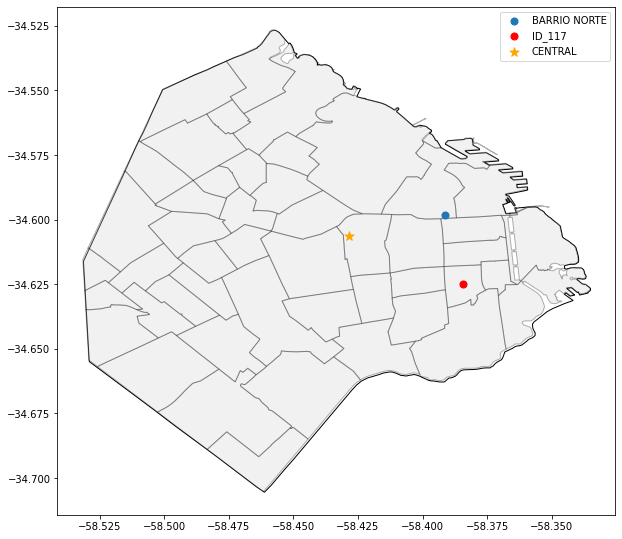

In [66]:
ax = capital.plot(color='white', edgecolor='black', figsize = (10,10), legend = True)  # Poligono de CABA
barrios_capital.plot(column = None, ax = ax, alpha = 0.3, edgecolor = 'k', color = 'lightgray') # Barrios de CABA
sede_cercana.plot(ax = ax , markersize = 50,  label =  sede_cercana.Sede[0])  # Punto de la sede mas cercana
usuario_df.plot(ax = ax, markersize = 50, color = 'red', label =  usuario_df.Usuario[0])  # Punto geografico del usuario
HI.plot(ax = ax, markersize = 90, marker = '*', color = 'orange', label = 'CENTRAL' )  # Punto geografico del  HI
plt.legend()

- Identificar el centro de salud mas cercano
- Identificar distancia de un profesional con sus pacientes (identificacion de clusters)
- Incluir ubicación geográfica como variable en diferentes modelos (clasificación y predicción)